# Utilizando embeddings de palavras pré-treinados para classificação de sentimento

*   Carregamento e Pré-processamento de Dataset do mundo real
*   Treino do modelo com Bag-of-Words
*   Treino do modelo de embeddings Word2Vec, TF-IDF
*   Split dos dados
*   Definição e Treino de uma Máquina de Vetores de Suporte

### Imports

In [1]:
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import gensim.downloader as api

## Carregando e pré-processando a nossa base de dados

In [2]:
with open('/content/review_data_Cyberpunk_2077.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.DataFrame(data)

df.sample(5)

,id,rating,review
1705,255981904,recomendado,Cyberpunk 2077 : A Breathtakingly Beautiful RP...
212,1249652201,recomendado,If this gets 1 like I'll eat my hat. Comrade
1983,55902355,recomendado,its fun
338,155246346,recomendado,"I don´t know what's with this game, but it nev..."
2007,229134026,não recomendado,I only review games on steam to complete those...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4000 non-null   int64 
 1   rating  4000 non-null   object
 2   review  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


## Bag-of-Words

In [4]:
# Processar os dados
reviews_BoW = [item['review'] for item in data]
ratings_BoW = [1 if item['rating'] == 'recomendado' else 0 for item in data]  # 1 para "recomendado", 0 caso contrário

# Converter texto em Bag of Words
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_BoW = vectorizer.fit_transform(reviews_BoW).toarray()
y_BoW = ratings_BoW

X_BoW_train, X_BoW_test, y_BoW_train, y_BoW_test = train_test_split(X_BoW, y_BoW, test_size=0.30, random_state=11)

## TF-IDF

In [5]:
# Processar os dados
reviews_TF_IDF = [item['review'] for item in data]
ratings_TF_IDF = [1 if item['rating'] == 'recomendado' else 0 for item in data]  # 1 para recomendado, 0 caso contrário

# Gerar embeddings usando TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
X_TF_IDF = tfidf.fit_transform(reviews_TF_IDF).toarray()
y_TF_IDF = ratings_TF_IDF

X_TF_IDF_train, X_TF_IDF_test, y_TF_IDF_train, y_TF_IDF_test = train_test_split(X_TF_IDF, y_TF_IDF, test_size=0.30, random_state=11)

## Treino do modelo Word2Vec

In [6]:
# Baixar dependências do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_d

True

In [7]:
tokenized_sents = [word_tokenize(i) for i in df['review'].values]

model_review = Word2Vec(tokenized_sents, vector_size=50, window=5, min_count=5, workers=4)

In [8]:
palavras = ['game', 'time', 'story', 'bugs', 'npc', 'city', 'hours', 'quest', 'missions', 'characters']
vetores = [model_review.wv[word] for word in palavras]

vetores_2d = PCA(random_state=0).fit_transform(vetores)[:, :2]

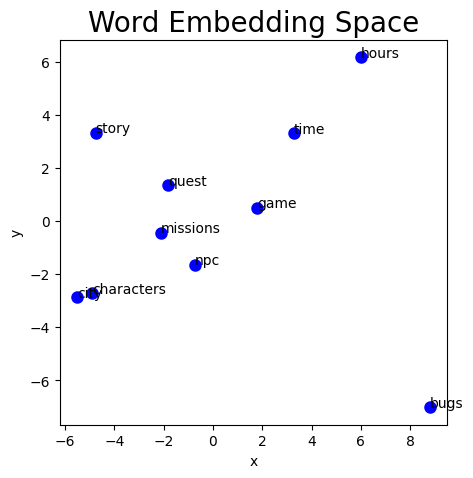

In [9]:
plt.figure(figsize=(5, 5))
plt.scatter(vetores_2d[:,0], vetores_2d[:,1], linewidths=3, color='blue')
plt.xlabel("x", size = 10)
plt.ylabel("y", size = 10)
plt.title("Word Embedding Space", size = 20)

for i, word in enumerate(palavras):
  plt.annotate(word, xy = (vetores_2d[i, 0], vetores_2d[i, 1]))

## Mais pré-processamento...

In [10]:
# Codificar labels
label_encoder = LabelEncoder()
df['rating'] = label_encoder.fit_transform(df['rating'])

import numpy as np
# Verificando o tamanho máximo do texto não estruturado (review)
X_Word2Vec, y_Word2Vec = [], []
max_len = 0
vector_dim = model_review.wv.vector_size

for i, row in df.iterrows():
  tokens = word_tokenize(row['review'])
  vectors = [model_review.wv[word] if word in model_review.wv else np.zeros(vector_dim) for word in tokens]
  max_len = max(max_len, len(vectors))
  X_Word2Vec.append(vectors)
  y_Word2Vec.append(row['rating'])
print("max_len: {}".format(max_len))

max_len: 1804


In [11]:
list(label_encoder.classes_)

['não recomendado', 'recomendado']

In [12]:
# Devemos utilizar um padding para padronizar o tamanho das nossas reviews em max_len.

X_Word2Vec = [seq for seq in X_Word2Vec if len(seq) > 0]
y_Word2Vec = [label for seq, label in zip(X_Word2Vec, y_Word2Vec) if len(seq) > 0]

def transform(exemplos, dimension, vector_dim):
  results = np.zeros((len(exemplos), dimension, vector_dim))
  for i, sequence in enumerate(exemplos):
    results[i, :len(sequence), :] = sequence
  return results

X_Word2Vec = transform(X_Word2Vec, max_len, model_review.wv.vector_size)
y_Word2Vec = np.array(y_Word2Vec).astype("float32")

In [13]:
X_Word2Vec.shape

(3997, 1804, 50)

In [14]:
X_Word2Vec_train, X_Word2Vec_test, y_Word2Vec_train, y_Word2Vec_test = train_test_split(X_Word2Vec, y_Word2Vec, test_size=0.30, random_state=11)

In [15]:
X_Word2Vec_train[0]

array([[ 0.53395855,  0.01159955,  0.25951904, ..., -0.45309106,
         0.1113231 ,  0.27602908],
       [-0.87025791,  0.45061246, -1.33340394, ..., -0.33162135,
         1.04108477,  1.30029309],
       [ 1.16371524, -0.98480952, -0.63463366, ..., -2.11625624,
         1.60067439,  0.93055505],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
# Gerar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.show()

# Gerar curva ROC
def plot_roc_curve(y_true, y_pred_prob):
    # Calcular fpr, tpr e auc para a classe positiva
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Curva ROC')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

## Classificador SVM

### Treino com Bag Of Words

In [17]:
# Treinar o modelo SVM com os dados de pré-processados por Bag Of Words
svm_model_BoW = SVC(kernel='linear', probability=True,random_state=11)
svm_model_BoW.fit(X_BoW_train, y_BoW_train)

SVC(kernel='linear', probability=True, random_state=11)

### Métricas com Bag Of Words

Relatório de classificação:
                 precision    recall  f1-score   support

não recomendado       0.80      0.73      0.77       603
    recomendado       0.75      0.81      0.78       597

       accuracy                           0.77      1200
      macro avg       0.78      0.77      0.77      1200
   weighted avg       0.78      0.77      0.77      1200



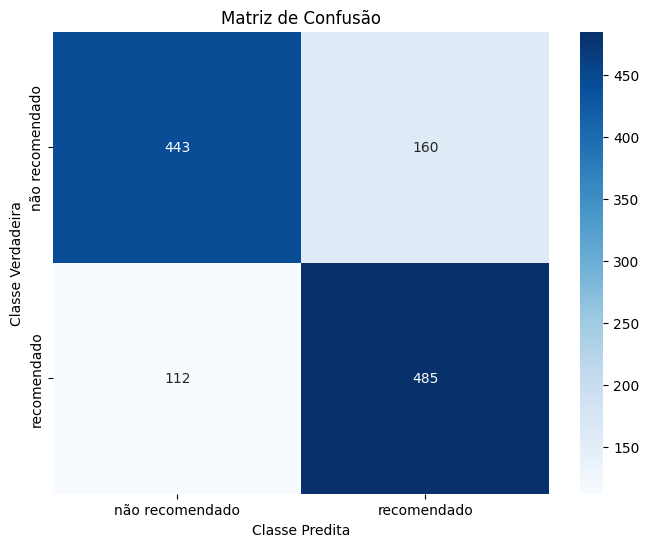

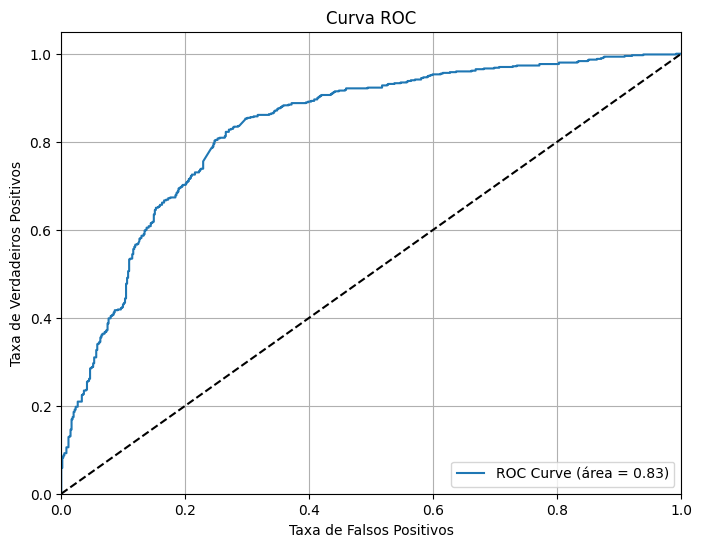

In [18]:
y_BoW_pred = svm_model_BoW.predict(X_BoW_test)

print("Relatório de classificação:")
print(classification_report(y_BoW_test, y_BoW_pred, target_names=['não recomendado', 'recomendado']))

plot_confusion_matrix(y_BoW_test, y_BoW_pred, ['não recomendado', 'recomendado'])

n_classes = len(['não recomendado', 'recomendado'])
y_BoW_pred_prob = svm_model_BoW.predict_proba(X_BoW_test)
plot_roc_curve(y_BoW_test, y_BoW_pred_prob)

### Treino com TF-IDF

In [19]:
# Treinar o modelo SVM com os dados de pré-processados por TF-IDF
svm_model_TF_IDF = SVC(kernel='linear', probability=True, random_state=11)
svm_model_TF_IDF.fit(X_TF_IDF_train, y_TF_IDF_train)

SVC(kernel='linear', probability=True, random_state=11)

### Métricas com TF-IDF

Relatório de classificação:
                 precision    recall  f1-score   support

não recomendado       0.83      0.80      0.82       603
    recomendado       0.80      0.84      0.82       597

       accuracy                           0.82      1200
      macro avg       0.82      0.82      0.82      1200
   weighted avg       0.82      0.82      0.82      1200



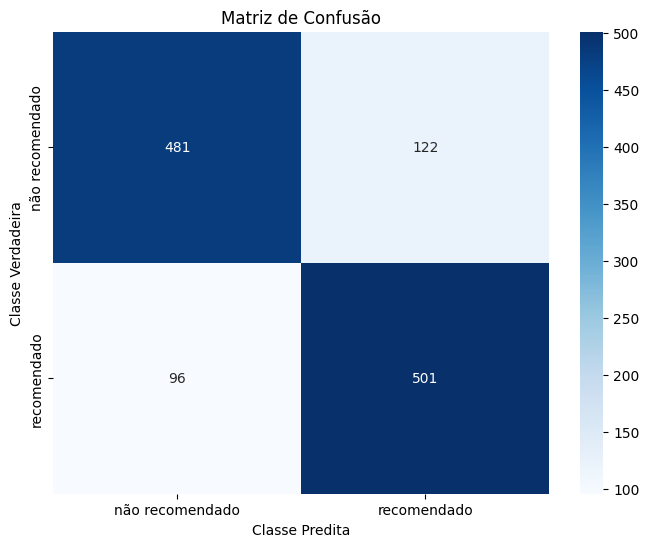

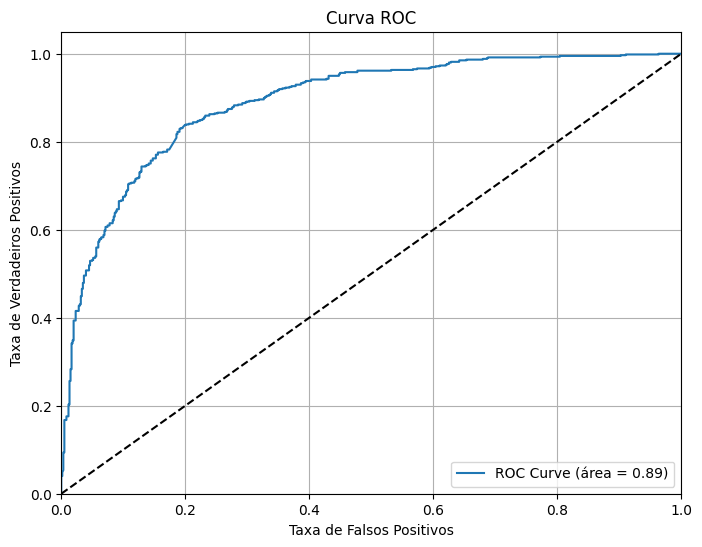

In [20]:
y_TF_IDF_pred = svm_model_TF_IDF.predict(X_TF_IDF_test)

print("Relatório de classificação:")
print(classification_report(y_TF_IDF_test, y_TF_IDF_pred, target_names=['não recomendado', 'recomendado']))

plot_confusion_matrix(y_TF_IDF_test, y_TF_IDF_pred, ['não recomendado', 'recomendado'])

y_TF_IDF_pred_prob = svm_model_TF_IDF.predict_proba(X_TF_IDF_test)
plot_roc_curve(y_TF_IDF_test, y_TF_IDF_pred_prob)

### Treino com Word2Vec

In [21]:
X_Word2Vec_train = X_Word2Vec_train.reshape(X_Word2Vec_train.shape[0], -1)
X_Word2Vec_test  = X_Word2Vec_test.reshape(X_Word2Vec_test.shape[0], -1)

svm_Word2Vec = SVC(kernel='linear', probability=True, random_state=11)
svm_Word2Vec.fit(X_Word2Vec_train, y_Word2Vec_train)

SVC(kernel='linear', probability=True, random_state=11)

### Métricas com Word2Vec

Relatório de classificação:
                 precision    recall  f1-score   support

não recomendado       0.56      0.56      0.56       610
    recomendado       0.55      0.55      0.55       590

       accuracy                           0.55      1200
      macro avg       0.55      0.55      0.55      1200
   weighted avg       0.55      0.55      0.55      1200



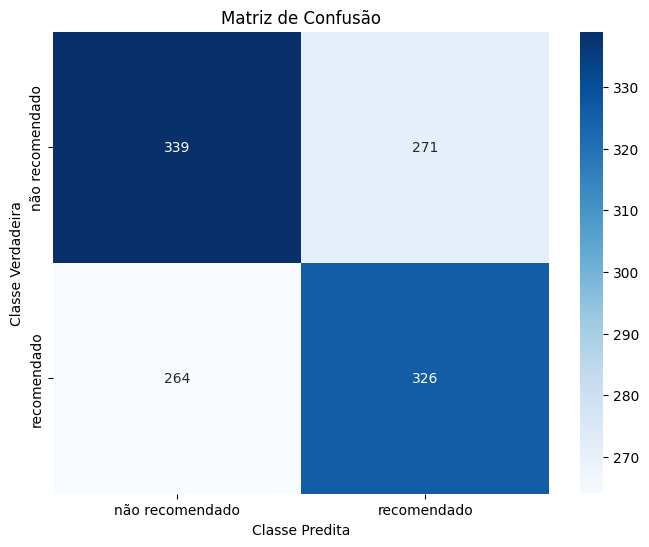

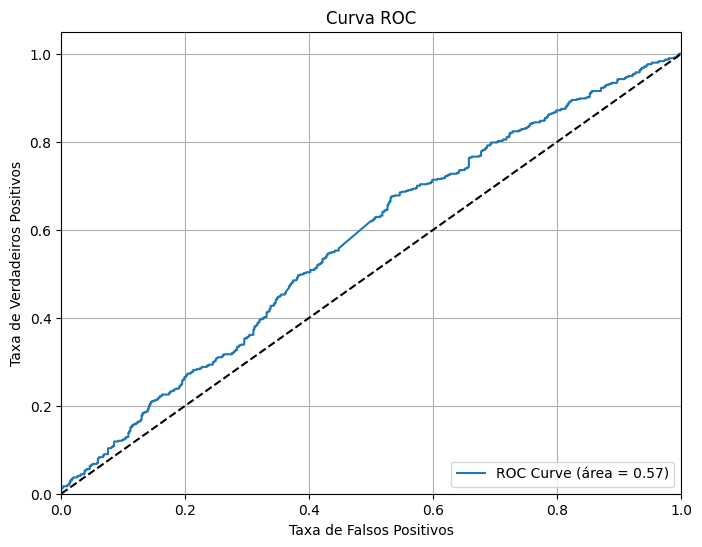

In [22]:
y_Word2Vec_pred = svm_Word2Vec.predict(X_Word2Vec_test)


print("Relatório de classificação:")
print(classification_report(y_Word2Vec_test, y_Word2Vec_pred, target_names=['não recomendado', 'recomendado']))

plot_confusion_matrix(y_Word2Vec_test, y_Word2Vec_pred, ['não recomendado', 'recomendado'])

y_Word2Vec_pred_prob = svm_Word2Vec.predict_proba(X_Word2Vec_test)
plot_roc_curve(y_Word2Vec_test, y_Word2Vec_pred_prob)